# Function for closing the mesh (Necessary for calculating the volume

In [29]:
import numpy as np

'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
from ddgclib._particle_liquid_bridge_20240303 import *

In [30]:
def curvature(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    #curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    #N_f0 = normalized(N_f0)[0]
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

In [31]:
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

    return HC, boundary_top, boundary_bottom, vat, vab

In [37]:
def plot_polyscope_plus_normvec(HC, normveccts):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir("z_up")

    do = coldict['db']
    lo = coldict['lb']
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    ps_cloud.set_color(tuple(do))
    #ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    ### Register a mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    surface = ps.register_surface_mesh("my mesh", verts, faces,
                             color=do,
                             edge_width=1.0,
                             edge_color=(0.0, 0.0, 0.0),
                             smooth_shade=False)

    # Add normal vectors
    vecs_vert = []
    for v in verts:
        N_f0 = v - np.array([0.0, 0.0, v[2]])
        N_f0 = normalized(N_f0)[0]
        #N_f0_vectors_pairs.append([v.x_a, N_f0])
        vecs_vert.append(N_f0)
    vecs_vert = np.array(vecs_vert) * 1e-4
    #surface.add_vector_quantity("N_f0 vectors", vecs_vert, radius=0.001,
    #                            length=0.005, color=(0.2, 0.5, 0.5))
    surface.add_vector_quantity("N_f0 vectors", vecs_vert, vectortype='ambient')

    ps.show()



# Functions for the contact-angle calculation

In [38]:
def b_disc_angle(v, r, bV, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)

    vij = []
    for vn in v.nn:
        if vn in bV:
            continue
        else:
            vij.append(vn)

    if 0:
        for vn in v.nn:
            if vn in bV:
                vij.append(vn)


    E_ij = vij[0].x_a - v.x_a
    E_ik = vij[1].x_a - v.x_a
    E_ij_ik = np.cross(E_ij, E_ik)
    E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
    dir_vec = E_ij_ik / E_ij_ik_norm

    if np.dot(N_f0, dir_vec) < 0:
        dir_vec = - dir_vec

    #K_H_i = c_outd['K_H_i']
    HNdA_i = c_outd['HNdA_i']
    C_ij = c_outd['C_ij']
    #HN_i = np.sum(HNdA_i) / np.sum(C_ij)
    n_i = c_outd['n_i']
    HN_i = np.sum(np.dot(HNdA_i, n_i)) / np.sum(C_ij)
    K_H_i = (HN_i/ 2.0)**2


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
       # print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')
        print(f'phi_est = {phi_est * 180 / np.pi}')
        print(f'E_ij = {E_ij}')
        print(f'E_ik = {E_ik}')
        print(f'E_ij_ik = {E_ij_ik}')
        print(f'dir_vec = {dir_vec}')
        print(f'np.dot(E_ij_ik_norm, dir_vec) = {np.dot(E_ij_ik_norm, dir_vec)}')
        print(f'E_ij_ik_norm = {E_ij_ik_norm}')
        print(f'vij = {vij}')

    return phi_est, dir_vec, E_ij, E_ik, E_ij_ik# , de # (sum of edge lengths)

# Functions for Particle-Particle liquid bridge

In [42]:

import copy


def fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax, contact_angle = True, load_activated = False,itermax_load = 10, save_activated = False,volume_constraint = False, V_init = 1):
    '''
    length = length of the inital cone [m]
    tau = size of time step [-]
    d_l = diameter one the lower site of the initial cyliner [m]
    d_u = diameter one the upper site of the initial cyliner [m]
    refinement = number of refinement of the mesh [-]
    theta_c = value of the contact angle in radian [rad]
    gamma = surface_tension [N/m]
    breaking_condition = when this value is reached, the simulation is finished [m]
    itermax = another breaking condition depending on the iteration steps [-]
    contact_angle = is the contact angle actived
    load_activated = with this parameter you have the choice to load a complex instead of creating a new on.
        if load_activated = False: A new mesh will be generated
    itermax_load = number of iteration of the loading complex (necessary paramter for loading the complex function:
    save_activated = with this parameter you have the choice to save the final complex
        if save_activated=False: Nothing happens
        if save_activated=True: The complex will saved under a savename depending on the inital parameters
    '''

    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')

    r_l = d_l / 2
    r_u = d_u / 2

    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''
    if load_activated:
        load_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_load)+'.json'
        HC = Complex(3)
        HC.load_complex(load_filename)
    else:
        HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)


    # Define bottom boundary condition
    boundary_bottom = []
   # N_f0_vectors_pairs = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)
            ###
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
          #  N_f0_vectors_pairs.append([v.x_a, N_f0])
            ##
    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
          #  N_f0_vectors_pairs.append([v.x_a, N_f0])

    # runvariable for the iteration tracking
    residual_iteration = 0

    #HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom)
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []
    contact_angle_list_bottom   = []
    contact_angle_list_top      = []

    '''
    ---------------------------------------------------------------------------------------------------------------------------
    From here, the optimization is started
    '''
    iters = 0
    while True:

        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')
            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")
            break
        '''
        Calculating the volume of the hole mesh in every volume
        '''

        if 1:
            V_current = 0
            number_v = 0
            HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom) # closing the boundary

            for v in HC.V:
                number_v += 1
                V_ijk = volume(v)
                V_current += np.sum(V_ijk)

            V_current = V_current/12
            print(f'V_current = {V_current}')
            volume_list.append(V_current)

            dV = (V_init-V_current)/V_init

            HC.V.remove(vat) # Open the boundary (Important, otherwise the angle-calculation will not work)
            HC.V.remove(vab) # Open the boundary (Important, otherwise the angle-calculation will not work)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}

        contact_angle_list_bottom_dummy = []
        contact_angle_list_top_dummy   = []
       # print(f'number of vertexes = {number_v}')
        cHC = copy.copy(HC)

        dV_dummy = copy.copy(dV)

        N_f0_vectors_pairs = []
        for v in cHC.V:
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])


            # Define bottom boundary condition
            if v in set(boundary_bottom):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_bottom, print_out=False)
                contact_angle_list_bottom_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)
                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) *gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0

                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Define top boundary condition
            if v in set(boundary_top):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_top, print_out=False)
               # contact_angle_list_top_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)

                for vnn in v.nn:
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                        contact_angle_list_top_dummy.append(phi_est)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) * gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            #df = np.dot(df, N_f0)*N_f0
           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys() and contact_angle:
                db = v_boundary_interior[v.x]  # normalized(HNdA_i)[0]
                df = np.zeros_like(HNdA_i)
               # df[0] = 0
               # df[1] = 0
               # df[2] = 0
               # db[2] = 0
            else:
                pass

            # Step in time
            if iters < 50:
                db = np.zeros_like(HNdA_i)
            else:
                db = db



           # db = np.dot(db, dir_vec)*dir_vec
           # df = np.dot(df, N_f0)*N_f0
           # df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)

            #v_new = v.x_a - tau/2 * df  + tau/2 * db old

            if volume_constraint and dV_dummy>0:
                if v in set(boundary_top):
                    dv = np.zeros_like(HNdA_i)
                if v in set(boundary_bottom):
                    dv = np.zeros_like(HNdA_i)
                else:
                    dv = np.dot(dV_dummy, N_f0) * N_f0
                #print(f'dV = {dV}')
                #print(f'dv = {dv}')

            else:
                dv = np.zeros_like(HNdA_i)

            if contact_angle: # contact angle constraint
                 db = np.dot(db, N_f0)*N_f0
                 #db = db
            else:
                db = np.zeros_like(HNdA_i)

            v_new = v.x_a - tau/2 * df  + tau/2 * db - tau/2 * dv

            '''
            if contact_angle: # condition if the contact angle is activated
                v_new = v.x_a - tau/2 * df  + tau/2 * db
            else:
                v_new = v.x_a - tau/2 * df
            '''

            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df+db))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        #contact_angle_list_bottom_dummy.append(phi_est) theta_p_approx * 180 / np.pi
        contact_angle_list_bottom.append(cal_average(contact_angle_list_bottom_dummy)* 180 / np.pi)
        contact_angle_list_top.append(cal_average(contact_angle_list_top_dummy)* 180 / np.pi)


        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break

        iters += 1

    if save_activated:
        if load_activated:
            itermax_save = itermax + itermax_load
        else:
            itermax_save = itermax

        save_filename = 'dl'+str(d_l)+'_du'+str(d_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_save)+'.json'
        save_complex(HC, save_filename)
        print(f'Complex is saved under the name: {save_filename}.')

    result_dict = {}
    result_dict['HC'] = HC

    result_dict['iteration_list'] = iteration_list
    result_dict['df_list_min'] = df_list_min
    result_dict['df_list_max'] = df_list_max
    result_dict['volume_list'] = volume_list
    result_dict['contact_angle_list_bottom'] = contact_angle_list_bottom
    result_dict['contact_angle_list_top'] = contact_angle_list_top
    result_dict['N_f0_vectors_pairs'] = N_f0_vectors_pairs
    result_dict['dHNdA_list_min'] = dHNdA_list_min
    result_dict['dHNdA_list_max'] = dHNdA_list_max


    return result_dict


    #return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max)

   # return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max,contact_angle_list_top_dummy)





# Variation and execution of the particle-particle-liquid function

In [44]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
'''
d_l = 0.8e-3 # radian on the lower side of the cone
d_l = 1.6e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 0.36 * 3e-3
d_l = d_u
length = 0.7e-3 # length of the cone
length = 0.294 * 3e-3
'''



tau = 0.1    # Endtime for calculation
tau = 1    # Endtime for calculation
itermax = 1



itermax_load = 25*1e3 # number of iteration of the loaded complex

'''
from Liam 19939
'''
r_i = 1e-3 # Particle Radian
#r_i = 1.0
#gamma = 72.28

gamma = 2.45e-3  # N/m, surface tension of di-n-butyl phthalate/liquid paraffin mixture
r_i = 15e-3 # Particle Radian

angle = 10 # angle from the liquid bridge depending of the particle-radian
S = 0.1 # dimensionless seperation distance
#S = 0.3 # dimensionless seperation distance

y_i = np.sin(angle * np.pi/180.0) * r_i # calculated radian of the liquid bridge
r_l = y_i
r_u = r_l
length = S * r_i


# TEST angle:
theta_p = 10 * np.pi/180.0  # Three phase contact angle

'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''
#length = 2
#d_l = 1
#d_u = d_l


breaking_condition = 1e-9
print(f'volume inital = {y_i**2 *np.pi * length * 0.05}')
#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)
#fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_N(r_l, r_u, length, refinement, theta_p,tau, gamma, breaking_condition,itermax,contact_angle = True, save_activated=False, load_activated=False, itermax_load = itermax_load, volume_constraint=True, V_init= y_i**2 *np.pi * length * 0.05)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)



volume inital = 1.598579039499559e-09
Simulation is started!
-------------------------------------
V_current = 1.8190873710493727e-09
number of iteration =0
Iteration elapsed: 0
Time elapsed:0.47 s
Amount of highest displacement: 1.86 mikrometer
V_current = 1.8190096857597288e-09
number of iteration =1
-------------------------------------
Too many iterations! Simulation is canceled!
Time elapsed for canceled Simulation: 0.77 s


In [45]:
plot_polyscope_plus_normvec(dummy_parameter2['HC'], dummy_parameter2['N_f0_vectors_pairs'])

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [6]:
HC = dummy_parameter2['HC']
iteration_list = dummy_parameter2['iteration_list']
df_list_max = dummy_parameter2['df_list_max']
volume_list = dummy_parameter2['volume_list']
contact_angle_list_bottom = dummy_parameter2['contact_angle_list_bottom']
contact_angle_list_top= dummy_parameter2['contact_angle_list_top']

In [39]:
i = 0
for v in HC.V:
    i+=1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [46]:
length*1e3


1.5

In [7]:
from ddgclib._plotting import *
plot_polyscope(HC)


#plot_polyscope(dummy_parameter2['HC'])

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 3
self.V[v].index = 5
self.V[v].index = 13
self.V[v].index = 19
self.V[v].index = 24
self.V[v].index = 31
self.V[v].index = 39
self.V[v].index = 53
self.V[v].index = 66
self.V[v].index = 78
self.V[v].index = 95
self.V[v].index = 102
self.V[v].index = 114
self.V[v].index = 131
self.V[v].index = 153
self.V[v].index = 159
self.V[v].index = 206
self.V[v].index = 211
self.V[v].index = 242
self.V[v].index = 255
self.V[v].index = 298
self.V[v].index = 309
self.V[v].index = 362
self.V[v].index = 382
self.V[v].index = 396
self.V[v].index = 408
self.V[v].index = 444
self.V[v].index = 451
self.V[v].index = 512
self.V[v].index = 523
self.V[v].index = 2
self.V[v].index = 4
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 14
self.V[v].i

# Plotting of the results

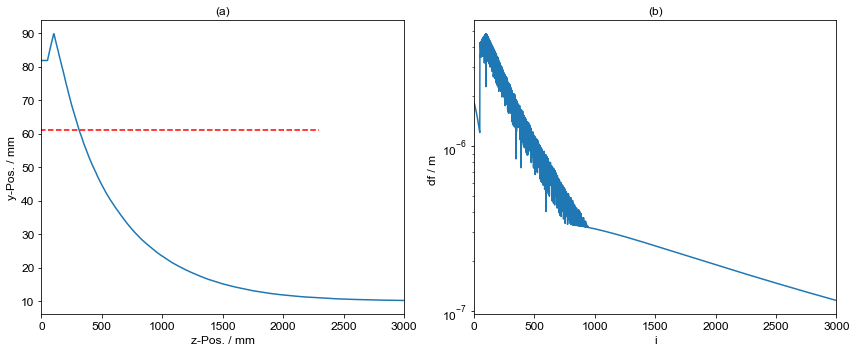

In [16]:
'''
Plot of the residual data
'''


plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

#fig_name = "contact_angle_notactivated10_20240219.png"
#fig_name = "example_calculation_lian_15000iteration.png"
#fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(6, 5))
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))

#ax[0].plot(vlist_z, vlist_y, linestyle = '--', markersize = 5, marker = 'o', linewidth = 1)
#ax[0].plot(coordiante_dict['vlist_z'], coordiante_dict['vlist_y'], linestyle = '--', markersize = 5, marker = 'o', linewidth = 1)

# ax[0].plot(coordiante_dict_500['vlist_z'], coordiante_dict_1000['vlist_y'], linestyle = '--', markersize = 5, marker = 'o', linewidth = 1)
ax[0].hlines(61,-10,2300, colors = 'red', linestyle = '--')
#*1e3
#ax[0].set_yscale('log')

ax[0].plot(iteration_list, contact_angle_list_top)
ax[1].plot(iteration_list, df_list_max)

#ax[1].plot(iteration_list, dHNdA_list_min)

#hlines(y, xmin, xmax, colors=None, linestyles='solid'

ax[0].set_title('(a)')
ax[1].set_title('(b)')

ax[0].set_xlabel("z-Pos. / mm")
ax[0].set_ylabel("y-Pos. / mm")

ax[1].set_xlabel("i")
ax[1].set_ylabel("df / m ")

#ax[0].set_ylim(45, 91)
ax[0].set_xlim(0, itermax)


ax[1].set_yscale('log')
#ax[1].set_ylim(0, 91)
ax[1].set_xlim(0, itermax)
#ax[0].legend()

plt.tight_layout()



#fig.savefig(fig_name)

In [31]:
a = np.array([-0.000122787809,-0.000122787809,9.9999e-5]) # erster Vektor am Rand
b = np.array([-0.000106318374, -0.000106318374, 8.74999969e-5]) # zweiter Vektor genau darunter
c = np.array([-5.35600375e-5, -0.000129305365, 9.37500008e-5]) # dritter Vektor rechts daneben
d = np.array([-0.0001299367, -5.38215463e-5, 9.37500008e-5]) # vierter Vektor links daneben
e = np.array([-3.18986532e-20, -0.000173648179,9.99999975e-5]) # theoretisch auf gleicher Höhe


def fun_dummy(x,y):
    result = np.dot(x,y) / (np.linalg.norm(x)*np.linalg.norm(y))
    angle_xxx = np.arccos(result)
    print(f'result = {result}')
    print(f'angle = {angle_xxx*180/np.pi}')

fun_dummy(a,e)

result = 0.7800492693971863
angle = 38.73491331714494


In [32]:
for i in range(len(contact_angle_list_top_dummy)):
    contact_angle_list_top_dummy[i]=contact_angle_list_top_dummy[i]/ 180 * np.pi

print(contact_angle_list_top_dummy)

NameError: name 'contact_angle_list_top_dummy' is not defined

In [ ]:
print(f'contact angle = {min(contact_angle_list_top)}')
print(f'volume = {volume_list[-1]*10e11}')
print(f'df_max = {df_list_max[-1]}')

In [ ]:
'''
Some not ready defined functions
'''
def b_force(v, theta_p, print_out=True):
    """
    The force on the three-phase contact angle
    Theta_i: Estimated sector angle of vertex i
    theta_p: Equilibrium three-phase contact angle
    """


    phi_est, l_a = b_disc_angle(v)
    # Compute boundary forces
    # N m-1
    gamma_bt = gamma * (np.cos(phi_est)
                        - np.cos(theta_p)) * np.array([0, 0, 1.0])

    if print_out:
        print(f'phi_est  = {phi_est * 180 / np.pi}')
        #print(f'dK[i] = {dK[i]}')
    return gamma_bt


def b_move_vertex(v, Theta_i, theta_p, print_out=True):
    """
    Move the boundary vertex
    """

    F_bt = gamma_bt * l_a  # N
    new_vx = v.x + 1e-1 * F_bt
    new_vx = tuple(new_vx)
    HC.V.move(v, new_vx)
    bV_new.add(HC.V[new_vx])

In [ ]:
'''
Plotting of the normvecs (dir_vecs)
'''

plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

# Using the Function